In [1]:
import numpy as np, random, operator, pandas as pd, matplotlib.pyplot as plt

# create city class with init and distance methods
class City:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def distance(self, city):
        xDis = abs(self.x - city.x)
        yDis = abs(self.y - city.y)
        distance = np.sqrt((xDis ** 2) + (yDis ** 2))
        return distance

# fitness class that calculates the distance between cities and sums them to obtain the total distance of the route
# then calculates the relative fitness (inverse of the distance)
class Fitness:
    def __init__(self, route):
        self.route = route
        self.distance = 0
        self.fitness= 0.0
    
    def routeDistance(self):
        if self.distance ==0:
            pathDistance = 0
            for i in range(0, len(self.route)):
                fromCity = self.route[i]
                toCity = None
                if i + 1 < len(self.route):
                    toCity = self.route[i + 1]
                else:
                    toCity = self.route[0]
                pathDistance += fromCity.distance(toCity)
            self.distance = pathDistance
        return self.distance
    
    def routeFitness(self):
        if self.fitness == 0:
            self.fitness = 1 / float(self.routeDistance())
        return self.fitness 
    
# creation of the initial population from randomly sampling the list then adding them to the population 
def createRoute(cityList):
    route = random.sample(cityList, len(cityList))
    return route

def initialPopulation(cityList, popSize):
    population = []

    for i in range(0, popSize):
        population.append(createRoute(cityList))
    return population

#creation of the genetic algorithm
#rank individuals
def rankRoutes(population):
    fitnessResults = {}
    for i in range(0,len(population)):
        fitnessResults[i] = Fitness(population[i]).routeFitness()
    return sorted(fitnessResults.items(), key = operator.itemgetter(1), reverse = True)

#selection function with Roulette Wheel
def selectionRoulette(popRanked, eliteSize):
    selectionResults = []
    df = pd.DataFrame(np.array(popRanked), columns=["Index","Fitness"])
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()
    
    for i in range(0, eliteSize):
        selectionResults.append(popRanked[i][0])
    for i in range(0, len(popRanked) - eliteSize):
        pick = 100*random.random()
        for i in range(0, len(popRanked)):
            if pick <= df.iat[i,3]:
                selectionResults.append(popRanked[i][0])
                break
    return selectionResults

#selection function with Rank
def selectionRank(popRanked, eliteSize):
    selectionResults = []
    df = pd.DataFrame(np.array(popRanked), columns=["Index","Fitness"])
    
    for i in range(0, eliteSize): #introduce elitism
        selectionResults.append(popRanked[i][0])
    for i in range(0, len(popRanked) - eliteSize):
        df["Rank"] = df.index.values.astype(int)
        df["Weight"] = 1/(df.Rank+1)
        #print(df)
        pick = random.random() #select a random weight to compare to the weights 
        for i in range(0, len(popRanked)): #and then select the mating pool in Results
            if pick <= df.iat[i,3]: 
                selectionResults.append(popRanked[i][0])
                break
    return selectionResults

#mating pool creation
def matingPool(population, selectionResults):
    matingpool = []
    for i in range(0, len(selectionResults)):
        index = selectionResults[i]
        matingpool.append(population[index])
    return matingpool

def breedTPC(parent1, parent2):
    child = []
    childP1 = []
    
    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))
    
    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)

    for i in range(startGene, endGene):
        childP1.append(parent1[i])
        
    child = [item for item in parent2 if item not in childP1]
    child[startGene:startGene] = childP1
    
    return child

def breedOPC(parent1, parent2):
    child = []
    childP1 = []
    childP2 = []
    gene = int(random.random() * len(parent1))

    for i in range(0, gene):
        childP1.append(parent1[i])

    child = [item for item in parent2 if item not in childP1]
    child[gene:gene] = childP1
    
    return child

#run the crossover over the whole pool
def breedPopulation(matingpool, breed, eliteSize):
    children = []
    length = len(matingpool) - eliteSize
    pool = random.sample(matingpool, len(matingpool))

    for i in range(0,eliteSize):
        children.append(matingpool[i])
    
    for i in range(0, length):
        if breed==0:
            child = breedOPC(pool[i], pool[len(matingpool)-i-1])
        else:
            child = breedTPC(pool[i], pool[len(matingpool)-i-1])
        children.append(child)
    return children

#Swap Mutation on two genes of the same individual
def mutateSw(individual, mutationRate):
    for swapped in range(len(individual)):
        if(random.random() < mutationRate):
            swapWith = int(random.random() * len(individual))
            
            city1 = individual[swapped]
            city2 = individual[swapWith]
            
            individual[swapped] = city2
            individual[swapWith] = city1
    return individual

#Scrumble Mutation on a set of genes of the same individual
def mutateSc(individual, mutationRate):
    if(random.random() < mutationRate):
        startGene= int(random.random()*len(individual))
        endGene= int(random.random()*len(individual))
        if endGene <= startGene:
            endGene += 1
        temp= individual[startGene:endGene]
        random.shuffle(temp)
        individual= individual[:startGene]+ temp + individual[endGene:]
            
    return individual

def mutatePopulation(population, mutationRate, mut):
    mutatedPop = []
    
    for ind in range(0, len(population)):
        if mut==0:
            mutatedInd = mutateSw(population[ind], mutationRate)
                    
        else:
            mutatedInd = mutateSc(population[ind], mutationRate)
           
        mutatedPop.append(mutatedInd)
    return mutatedPop

def nextGeneration(currentGen, sel, mut, breed, eliteSize, mutationRate):
    popRanked= rankRoutes(currentGen)
    
    if sel == 0:
        selectionResults = selectionRoulette(popRanked, eliteSize)
    else:
        selectionResults = selectionRank(popRanked, eliteSize)
        
    matingpool = matingPool(currentGen, selectionResults)
    children = breedPopulation(matingpool, breed, eliteSize)
    nextGeneration = mutatePopulation(children, mutationRate, mut)    
    return nextGeneration


#define the genetic algorithm
def geneticAlgorithm(pop, sel, mut, breed, eliteSize, mutationRate, generations): 
    progress=[]
    #pop = initialPopulation(popSize, population)  
    for i in range(0, generations):
        pop = nextGeneration(pop, sel, mut, breed, eliteSize, mutationRate)
        progress.append(1 / rankRoutes(pop)[0][1])
    
    print("Final distance: " + str(1 / rankRoutes(pop)[0][1]))
    bestRouteIndex = rankRoutes(pop)[0][0]
    bestRoute = pop[bestRouteIndex]
    printRoute(bestRoute)
    
    plt.plot(progress)
    plt.ylabel('Distance')
    plt.xlabel('Generation')
    plt.show()     
    
cityList = [City(8,71),City(9,85),City(7,102),City(10,139),City(37,165),City(48,186),City(68,189),City(92,161),
 City(109,179),City(162,190),City(190,192),City(188,186),City(182,180),City(178,162),City(195,136),City(186,133),
 City(172,105),City(154,90),City(158,76),City(177,53),City(181,41),City(178,20),City(186,4),City(172,21),City(141,25),
 City(122,50),City(130,81),City(132,99),City(73,114),City(70,54)]
    
def printRoute(cityList):
    xs=[]
    ys=[]
    for i in range(0, len(cityList)):
        x=cityList[i].x
        xs.append(x)
        y=cityList[i].y
        ys.append(y)
        #plt.scatter(x,y)
    plt.plot(xs,ys,'-o')
    plt.grid(True)
    plt.show()
    

Initial distance: 2719.6768103392847


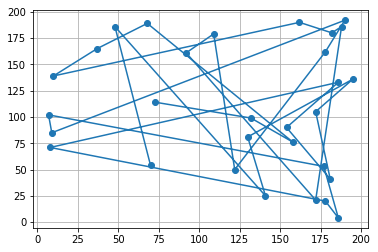

In [2]:
progress = []
population = cityList
pop = initialPopulation(population, popSize=100)
print("Initial distance: " + str(1 / rankRoutes(pop)[0][1]))
initialRouteIndex=rankRoutes(pop)[0][0]
initialRoute=pop[initialRouteIndex]
printRoute(initialRoute)
progress.append(1 / rankRoutes(pop)[0][1])

#sel 0 roulette
#sel 1 rank
#mut 0 swap
#mut 1 scrumble
#breed 0 opc
#breed 1 tpc

Final distance: 932.2757716725806


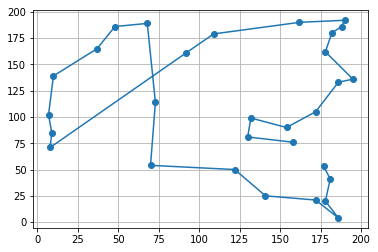

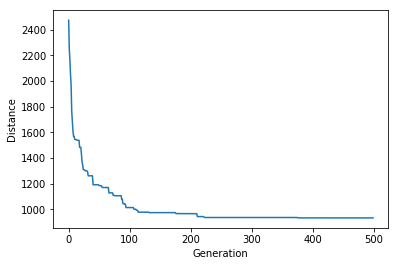

In [3]:
geneticAlgorithm(pop, sel=1, mut=0, breed=0, eliteSize=20, mutationRate=0.01, generations=500)#rank, swap, opc

Final distance: 1208.9359129682139


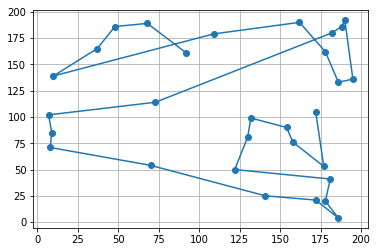

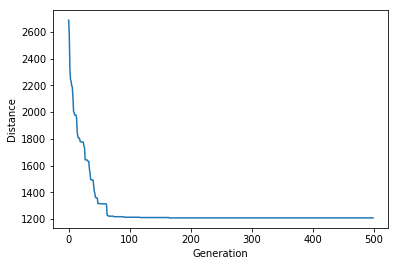

In [4]:
geneticAlgorithm(pop, sel=1, mut=0, breed=1, eliteSize=20, mutationRate=0.01, generations=500)#rank, swap, tpc

Final distance: 1023.1953535479174


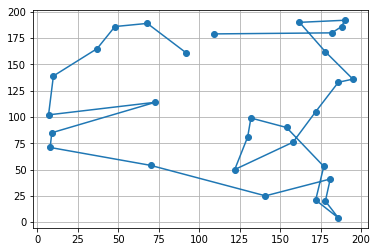

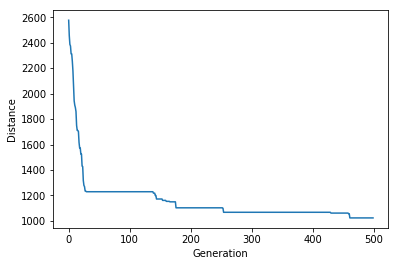

In [5]:
geneticAlgorithm(pop, sel=1, mut=1, breed=0, eliteSize=20, mutationRate=0.01, generations=500)#rank, scrumble, opc

Final distance: 1659.1850038867444


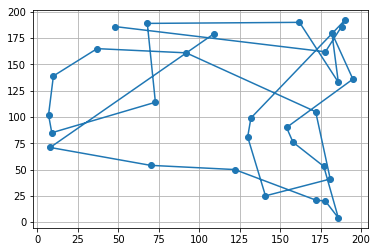

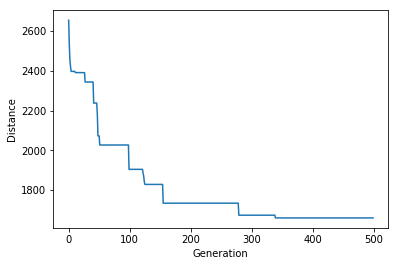

In [6]:
geneticAlgorithm(pop, sel=1, mut=1, breed=1, eliteSize=20, mutationRate=0.01, generations=500)#rank, scrumble, tpc

Final distance: 838.2526658699068


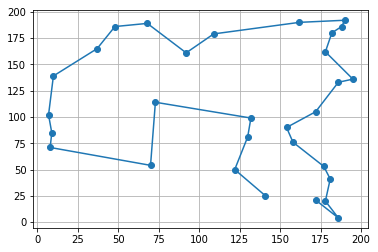

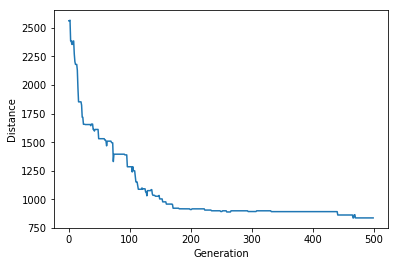

In [7]:
geneticAlgorithm(pop, sel=0, mut=0, breed=0, eliteSize=20, mutationRate=0.01, generations=500)#roulette, swap, opc

Final distance: 922.527929231229


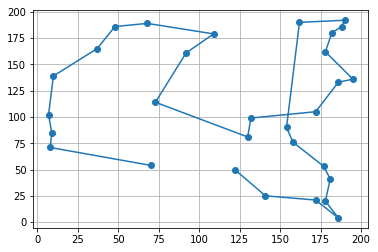

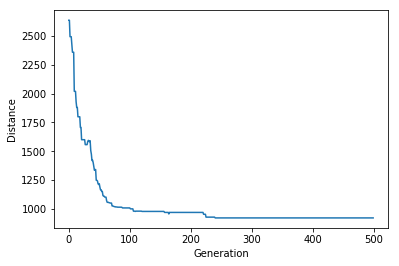

In [8]:
geneticAlgorithm(pop, sel=0, mut=0, breed=1, eliteSize=20, mutationRate=0.01, generations=500)#roulette, swap, tpc

Final distance: 870.098275874756


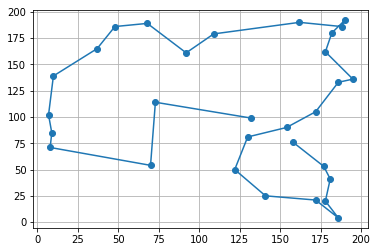

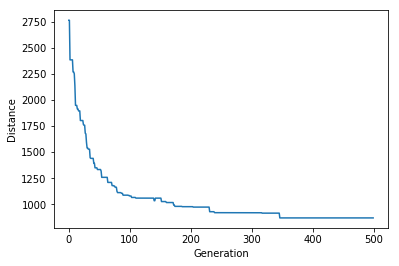

In [9]:
geneticAlgorithm(pop, sel=0, mut=1, breed=0, eliteSize=20, mutationRate=0.01, generations=500)#roulette, scrumble, opc

Final distance: 1056.6422605366986


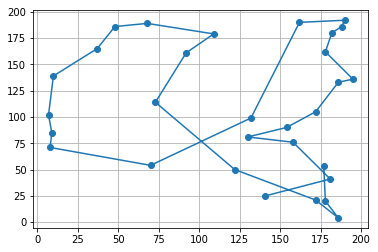

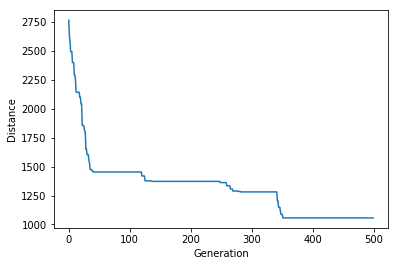

In [10]:
geneticAlgorithm(pop, sel=0, mut=1, breed=1, eliteSize=20, mutationRate=0.01, generations=500)#roulette, scrumble, tpc